In [4]:
import urllib
import json
import datetime
import time
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup


In [5]:
client_id = "_EUURgVrzICcMLZIaRGG"
client_secret = "fCRKPL9mlj"

In [6]:
# 네이버 API 상세검색에서 연도를 지정해줄 범위와 키워드 설정
years_start = [19600101, 20050101, 20100101, 20160101, 20180101, 20200101]
years_end = [20041231, 20091231, 20151231, 20171231, 20191231, 20220426]
category = [280, 250, 160]

keywords = ['Python', '파이썬', 'C', 'C 언어', 'Java', '자바', 'C++', 'C#', 'Visual Basic', '비주얼 베이직', 'JavaScript', '자바스크립트', 'SQL', 'PHP', 'R', 'R 언어']

In [7]:
# 
# url 설정: 상세검색으로 타이틀과 연도를 지정해준다.
def get_url(search_text, start_num, disp_num, years_start, years_end, category):
    base = "https://openapi.naver.com/v1/search/book_adv.json"
    param_query = "?d_titl=" + urllib.parse.quote(search_text)
    param_start = "&start=" + str(start_num)
    param_disp = "&display=" + str(disp_num)
    param_start = "&d_dafr=" + str(years_start)
    param_end = "&d_dato=" + str(years_end)
    param_cat = "&d_catg=" + str(category)
    
    return base + param_query + param_start + param_disp + param_start + param_end + param_cat

In [8]:
# 검색 결과 저장
def get_result_onpage(url):
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    response = urllib.request.urlopen(request)
    print("[%s] Url Request Success" % datetime.datetime.now())
    return json.loads(response.read().decode("utf-8"))

In [9]:
# 타이틀에 포함되는 tag를 삭제
def delete_tag(input_str):
    input_str = input_str.replace("<b>", "")
    input_str = input_str.replace("</b>", "")
    return input_str

In [10]:
# 책에대한 정보를 긁어오는 함수.
# 제목, 저자, 가격, 출판사, isbn, 출판연도, 그리고 상세검색어를 데이터프레임에 넣어준다
def get_info(contents, keyword):
    tmp_lst = []
    for book in contents['items']:
        title = delete_tag(book['title'])
        author = book['author']
        price = book['price']
        publisher = book['publisher']
        pubdate = book['pubdate']
        link = book['link']

        try:
            isbn = book['isbn'].split()[0]
        except:
            continue

        tmp_lst.append({
                "title":title,
                "author":author,
                "price":price,
                "publisher":publisher,
                "isbn":isbn,
                "pubdate":pubdate,
                "keyword":keyword,
                "link":link
            })
        

    tmp_df = pd.DataFrame(tmp_lst)
    return tmp_df

In [11]:
book_df = pd.DataFrame()

In [12]:
# 반복문을 돌려 각 검색어의 책 정보를 불러모아 book_df에 저장
for query in keywords:
    for cat in category:    
        for i in range(6):
            start = years_start[i]
            end = years_end[i]
            for n in range(1, 1000, 100):
                url = get_url(query, n, 100, start, end, cat)
                one_result = get_result_onpage(url)
                tmp_df = get_info(one_result, query)

            book_df = pd.concat([book_df, tmp_df], ignore_index=True)
            time.sleep(1)

[2022-06-29 09:02:26.559168] Url Request Success
[2022-06-29 09:02:26.640302] Url Request Success
[2022-06-29 09:02:26.724733] Url Request Success
[2022-06-29 09:02:26.798842] Url Request Success
[2022-06-29 09:02:26.859927] Url Request Success
[2022-06-29 09:02:26.928469] Url Request Success
[2022-06-29 09:02:26.993067] Url Request Success
[2022-06-29 09:02:27.059534] Url Request Success
[2022-06-29 09:02:27.127400] Url Request Success
[2022-06-29 09:02:27.194357] Url Request Success
[2022-06-29 09:02:28.279861] Url Request Success
[2022-06-29 09:02:28.375973] Url Request Success
[2022-06-29 09:02:28.457114] Url Request Success
[2022-06-29 09:02:28.522555] Url Request Success
[2022-06-29 09:02:28.600174] Url Request Success
[2022-06-29 09:02:28.676669] Url Request Success
[2022-06-29 09:02:28.751228] Url Request Success
[2022-06-29 09:02:28.814133] Url Request Success
[2022-06-29 09:02:28.890930] Url Request Success
[2022-06-29 09:02:28.959402] Url Request Success
[2022-06-29 09:02:30

In [13]:
book_df.to_csv("./book_df.csv", encoding="utf-8", index=False)

In [14]:
book_df = pd.read_csv("./book_df.csv", encoding='utf-8-sig')


In [15]:
book_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5711 entries, 0 to 5710
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      5711 non-null   object 
 1   author     5708 non-null   object 
 2   price      5709 non-null   float64
 3   publisher  5711 non-null   object 
 4   isbn       5711 non-null   object 
 5   pubdate    5711 non-null   int64  
 6   keyword    5711 non-null   object 
 7   link       5711 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 357.1+ KB


## 2. 데이터 전처리

### 2.1 중복데이터 제거

In [16]:
# isbn
duplicates = book_df.duplicated(['isbn'])
duplicates.value_counts()

False    4449
True     1262
dtype: int64

In [17]:
# 중복 데이터 제거
book_df = book_df.drop_duplicates(['isbn'], keep = 'first').reset_index(drop=True)


### 2.2 비어있는 isbn 찾기

In [18]:
# isbn 값이 없는 행을 조회해본 결과, 존재하지 않음을 확인하였음.
book_df[book_df['isbn'].isna()]

,title,author,price,publisher,isbn,pubdate,keyword,link


### 2.3 가격 데이터 float 형태로 변환

In [19]:
# 위에 .info를 찍어 보았을 때, price에 null값이 들어가 있는 행을 확인하였다. 그러므로 널값 조회.
book_df[book_df['price'].isna()]


,title,author,price,publisher,isbn,pubdate,keyword,link
1287,"양질의 시간제 고용을 찾아서 (Colette Fagan, Helen Norman, ...",Colette Fagan|Helen Norman|Mark Smith|Maria <b...,NaN,노사발전재단,898958390X,20131220,C,http://book.naver.com/bookdb/book_detail.php?b...
2623,Thinking About: C++ STL 프로그래밍,최흥배,NaN,한빛미디어(주),897914993X,20121221,C++,http://book.naver.com/bookdb/book_detail.php?b...


- 네이버 책에 각 책을 검색해본 결과, 첫번째 책은 "C"라는 저자 이름이 들어가서 포함된 것으로 보이며, 프로그래밍 언어와 무관한 책이므로 삭제하기로 결정
- 두번째 책은 C++에 관한 책이고, 무료로 전자책 형태로 배포되므로 가격이 0이 옳다 판단되어 NaN 보다는 0으로 replace하기로 함

In [20]:
# C++ 책의 값을 0으로 변환
book_df.loc[2626, 'price'] = 0.


In [21]:
# 첫번째 책의 데이터 삭제 
book_df = book_df.drop(labels=1289, axis=0).reset_index()

In [22]:
# price 데이터 float형으로 변환
book_df['price'] = book_df['price'].astype(float)

In [23]:
book_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4448 entries, 0 to 4447
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      4448 non-null   int64  
 1   title      4448 non-null   object 
 2   author     4446 non-null   object 
 3   price      4446 non-null   float64
 4   publisher  4448 non-null   object 
 5   isbn       4448 non-null   object 
 6   pubdate    4448 non-null   int64  
 7   keyword    4448 non-null   object 
 8   link       4448 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 312.9+ KB


### 2.4 author 컬럼 탐색

In [24]:
book_df = book_df.drop('index', axis=1)

In [25]:
# 위에 .info를 찍어 보았을 때, author컬럼에 null값이 들어가 있는 행을 확인하였다. 그러므로 널값 조회.
book_df[book_df['author'].isna()]


,title,author,price,publisher,isbn,pubdate,keyword,link
1217,A&C 설계경기 (격월간) : 59호,NaN,25000.0,산업도서출판공사,12287970,20060601,C,http://book.naver.com/bookdb/book_detail.php?b...
3883,핵심적인 실무 내용 중심의 PHP-HTC 모듈 레퍼런스 (표지표제: 핵심적인 실무...,NaN,25000.0,크라운출판사,8940693507,2007,PHP,http://book.naver.com/bookdb/book_detail.php?b...


- index 1219의 책은 제목만 봐도 C와 상관 없는 책으로 판단되어 삭제하기로 함.
- index 3886의 책은 찾아본 결과 저자에 "김현철" 이라고 적혀 있다. 그러므로 author를 "김현철"이라고 지정해 주기로 함.

In [26]:
# 3886 책 저자 변환
book_df.loc[3886, 'author'] = "김현철"

# 1219 데이터 삭제
book_df = book_df.drop(labels=1219, axis=0).reset_index(drop=True)

In [27]:
# 데이터의 행 수가 모두 일정한 것을 확인함.
book_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4447 entries, 0 to 4446
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      4447 non-null   object 
 1   author     4445 non-null   object 
 2   price      4445 non-null   float64
 3   publisher  4447 non-null   object 
 4   isbn       4447 non-null   object 
 5   pubdate    4447 non-null   int64  
 6   keyword    4447 non-null   object 
 7   link       4447 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 278.1+ KB


#

### 2.5 출판 연도 열 추가

In [28]:
# pubdate 컬럼의 첫 4개만 들고와서 year로 지정.
book_df['year'] = book_df['pubdate'].astype(str).str[:4].astype(int)

In [29]:
book_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4447 entries, 0 to 4446
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      4447 non-null   object 
 1   author     4445 non-null   object 
 2   price      4445 non-null   float64
 3   publisher  4447 non-null   object 
 4   isbn       4447 non-null   object 
 5   pubdate    4447 non-null   int64  
 6   keyword    4447 non-null   object 
 7   link       4447 non-null   object 
 8   year       4447 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 312.8+ KB


In [30]:
book_df.head(3)

,title,author,price,publisher,isbn,pubdate,keyword,link,year
0,JUMP TO PYTHON,박응용,17000.0,정보게이트,8981611211,20010808,Python,http://book.naver.com/bookdb/book_detail.php?b...,2001
1,PYTHON 포켓 레퍼런스,마크 루츠,4600.0,한빛미디어,897914086X,20001010,Python,http://book.naver.com/bookdb/book_detail.php?b...,2000
2,PYTHON AND TKINTER PROGRAMMING,JOHN E.GRAYSON,28000.0,인포북,8980544243,20001101,Python,http://book.naver.com/bookdb/book_detail.php?b...,2000


### 2.6 프로그래밍 언어 추가

In [31]:
book_df['language'] = book_df['keyword']


In [32]:
# 각 키워드를 Language 컬럼에 언어 이름으로
for index, row in book_df.iterrows():
    if "파이썬" in row['keyword']:
        book_df.loc[index, 'language'] = "Python"
    elif "C 언어" in row['keyword']:
        book_df.loc[index, 'language'] = "C"
    elif "자바" in row['keyword'] and "자바스크립트" not in row['keyword']:
        book_df.loc[index, 'language'] = "Java"
    elif "비주얼 베이직" in row['keyword']:
        book_df.loc[index, 'language'] = "Visual Basic"
    elif "자바스크립트" in row['keyword']:
        book_df.loc[index, 'language'] = "JavaScript"
    elif "R 언어" in row['keyword']:
        book_df.loc[index, 'language'] = "R"

In [33]:
book_df.head(3)


,title,author,price,publisher,isbn,pubdate,keyword,link,year,language
0,JUMP TO PYTHON,박응용,17000.0,정보게이트,8981611211,20010808,Python,http://book.naver.com/bookdb/book_detail.php?b...,2001,Python
1,PYTHON 포켓 레퍼런스,마크 루츠,4600.0,한빛미디어,897914086X,20001010,Python,http://book.naver.com/bookdb/book_detail.php?b...,2000,Python
2,PYTHON AND TKINTER PROGRAMMING,JOHN E.GRAYSON,28000.0,인포북,8980544243,20001101,Python,http://book.naver.com/bookdb/book_detail.php?b...,2000,Python


In [34]:
book_df['language'].value_counts()


C               930
Java            902
Python          584
R               517
SQL             370
Visual Basic    335
C++             278
C#              226
PHP             161
JavaScript      144
Name: language, dtype: int64

In [35]:
# 전처리 후 한번더 저장
book_df.to_csv("./after_pretreatment_book.csv", encoding='utf-8-sig', index=False)


### 2.7 페이지 수 추가

In [36]:
from selenium import webdriver
from urllib.request import urlopen
import re

In [37]:
for i in range(len(book_df)):
    url = book_df['link'][i]
    response = urlopen(url)
    page = BeautifulSoup(response, 'html.parser')
    
    # Ebook의 경우에는 페이지 수가 존재하지 않는 경우도 있는것으로 판단.
    try:   
        tmp = page.find_all(class_= "book_info")[0].get_text()
        page_num = re.search("페이지\s+\d+", tmp).group().split()[1]
        
        book_df.loc[i, 'page_num'] = page_num
        print(i, page_num, url)

    except:
        print("======  ", i, "  ======", url)

0 454 http://book.naver.com/bookdb/book_detail.php?bid=60485
1 106 http://book.naver.com/bookdb/book_detail.php?bid=53401
2 852 http://book.naver.com/bookdb/book_detail.php?bid=57637
3 1278 http://book.naver.com/bookdb/book_detail.php?bid=118341
4 612 http://book.naver.com/bookdb/book_detail.php?bid=40001
5 928 http://book.naver.com/bookdb/book_detail.php?bid=6315947
6 366 http://book.naver.com/bookdb/book_detail.php?bid=3078103
7 432 http://book.naver.com/bookdb/book_detail.php?bid=7821202
8 690 http://book.naver.com/bookdb/book_detail.php?bid=7418047
9 520 http://book.naver.com/bookdb/book_detail.php?bid=7821203
10 248 http://book.naver.com/bookdb/book_detail.php?bid=8989825
11 348 http://book.naver.com/bookdb/book_detail.php?bid=9566723
12 308 http://book.naver.com/bookdb/book_detail.php?bid=7427286
13 120 http://book.naver.com/bookdb/book_detail.php?bid=7456027
14 1341 http://book.naver.com/bookdb/book_detail.php?bid=6933680
15 184 http://book.naver.com/bookdb/book_detail.php?bid=9

HTTPError: HTTP Error 500: Internal Server Error

In [41]:
# 첫번째 시도에서 index 1292에서 HTTP Error 500이 떴다. 1292만 돌려본 결과 아래와 같은 에러가 또 뜬다.
url = book_df['link'][1292]
response = urlopen(url)
page = BeautifulSoup(response, 'html.parser')

HTTPError: HTTP Error 500: Internal Server Error

In [42]:
book_df[:5]

,title,author,price,publisher,isbn,pubdate,keyword,link,year,language,page_num
0,JUMP TO PYTHON,박응용,17000.0,정보게이트,8981611211,20010808,Python,http://book.naver.com/bookdb/book_detail.php?b...,2001,Python,454
1,PYTHON 포켓 레퍼런스,마크 루츠,4600.0,한빛미디어,897914086X,20001010,Python,http://book.naver.com/bookdb/book_detail.php?b...,2000,Python,106
2,PYTHON AND TKINTER PROGRAMMING,JOHN E.GRAYSON,28000.0,인포북,8980544243,20001101,Python,http://book.naver.com/bookdb/book_detail.php?b...,2000,Python,852
3,PYTHON HOW TO PROGRAM,하비 디텔,45000.0,PEARSONEDUCATIONKOREA,8945071407,20021226,Python,http://book.naver.com/bookdb/book_detail.php?b...,2002,Python,1278
4,PYTHON 21일 완성,곽준기,17000.0,삼각형,8974674351,19980117,Python,http://book.naver.com/bookdb/book_detail.php?b...,1998,Python,612


In [44]:
book_df.loc[1292, :]

title                               C의 유전자 (회사 위에 존재하는 자들의 비밀)
author                                                제갈현열|강대준
price                                                  18000.0
publisher                                                 다산북스
isbn                                                1130634426
pubdate                                               20210101
keyword                                                      C
link         http://book.naver.com/bookdb/book_detail.php?b...
year                                                      2021
language                                                     C
page_num                                                   NaN
Name: 1292, dtype: object

- 긁어온 링크를 브라우저에 붙여 넣어본 결과, 위와 같은 정보가 뜬다.
- 500 에러는 지속해서 뜨지만, 브라우저에서 열때는 문제 없기에 보여지는 페이지 수 320을 직접 입력하기로 함.

In [45]:
book_df.loc[1292, 'page_num'] = 320

In [49]:
# 1292부터 다시 반복문을 돌림. 

for i in range(1293, len(book_df)):
    url = book_df['link'][i]
    response = urlopen(url)
    page = BeautifulSoup(response, 'html.parser')
    
    # Ebook의 경우에는 페이지 수가 존재하지 않는 경우도 있는것으로 판단된다.
    try:   
        tmp = page.find_all(class_= "book_info")[0].get_text()
        page_num = re.search("페이지\s+\d+", tmp).group().split()[1]
        
        book_df.loc[i, 'page_num'] = page_num
        print(i, page_num, url)

    except:
        print("======  ", i, "  ======", url)
    
    time.sleep(1)

1293 284 http://book.naver.com/bookdb/book_detail.php?bid=17358732
1294 306 http://book.naver.com/bookdb/book_detail.php?bid=20880584
1295 320 http://book.naver.com/bookdb/book_detail.php?bid=20633674
1296 594 http://book.naver.com/bookdb/book_detail.php?bid=150651
1297 324 http://book.naver.com/bookdb/book_detail.php?bid=1353334
1298 352 http://book.naver.com/bookdb/book_detail.php?bid=1419653
1299 1004 http://book.naver.com/bookdb/book_detail.php?bid=122591
1300 200 http://book.naver.com/bookdb/book_detail.php?bid=68959
1301 350 http://book.naver.com/bookdb/book_detail.php?bid=42212
1302 612 http://book.naver.com/bookdb/book_detail.php?bid=235132
1303 416 http://book.naver.com/bookdb/book_detail.php?bid=253618
1304 574 http://book.naver.com/bookdb/book_detail.php?bid=115485
1305 450 http://book.naver.com/bookdb/book_detail.php?bid=98860
1306 364 http://book.naver.com/bookdb/book_detail.php?bid=207635
1307 379 http://book.naver.com/bookdb/book_detail.php?bid=127107
1308 464 http://boo

In [50]:
# 페이지 정보가 없는 경우 확인
len(book_df[book_df['page_num'].isna()])

91

- ebook으로만 출판된 경우, 페이지 수가 제공되지 않았다
- 또한 ebook이면 가격이 상대적으로 낮게 출판 되기에, page_num이 null값이면서 가격이 높은 순으로 정렬하여 검색하여 보았다.

In [51]:
# 가격 내림차순으로 찾아보기
book_df[book_df['page_num'].isna()].sort_values(by=['price'], ascending=False)[:20]

,title,author,price,publisher,isbn,pubdate,keyword,link,year,language,page_num
4314,노인정신장애검사 CAMDEX-R,Martin Roth,65000.0,하나의학사,0002077825,20080212,R,http://book.naver.com/bookdb/book_detail.php?b...,2008,R,NaN
1416,C++ 프로그래밍 언어,비야네 스트롭스트룹,50000.0,피어슨에듀케이션코리아,8945072098,20050420,C 언어,http://book.naver.com/bookdb/book_detail.php?b...,2005,C,NaN
2106,소설같은 자바 (전4권),최영관,48000.0,자북,8989984149,20080410,자바,http://book.naver.com/bookdb/book_detail.php?b...,2008,Java,NaN
4114,앤디 필드의 유쾌한 R 통계학,앤디 필드|제레미 마일스|조이 필드,48000.0,제이펍,118862136X,20190228,R,http://book.naver.com/bookdb/book_detail.php?b...,2019,R,NaN
3294,HTML & JAVA SCRIPT 사전 (SET+다이어리),편집부,46000.0,영진닷컴,470600585X,20011221,JavaScript,http://book.naver.com/bookdb/book_detail.php?b...,2001,JavaScript,NaN
821,명품 C언어 프로젝트 (응용 프로그램 개발을 위한),안기수,33000.0,생능출판사,8970506624,20100415,C,http://book.naver.com/bookdb/book_detail.php?b...,2010,C,NaN
2050,루씬 인 액션 (오픈소스 자바 검색엔진),오티스 고스포드네티치,30000.0,에이콘출판,8989975786,20051015,자바,http://book.naver.com/bookdb/book_detail.php?b...,2005,Java,NaN
459,자연어 처리 쿡북 with 파이썬 (파이썬으로 NLP를 구현하는 60여 가지 레시피),크리슈나 바브사|나레쉬 쿠마르|프라탑 단게티,30000.0,에이콘출판,116175265X,20190131,파이썬,http://book.naver.com/bookdb/book_detail.php?b...,2019,Python,NaN
3923,바쁜 팀장님 대신 알려주는 신입 PHP 개발자 안내서,이현석,30000.0,업투데이트북스,1196276609,20180119,PHP,http://book.naver.com/bookdb/book_detail.php?b...,2018,PHP,NaN
1826,명품 HTML5 + CSS3 + Javascript 웹 프로그래밍,황기태,28000.0,생능출판,8970508880,20170116,Java,http://book.naver.com/bookdb/book_detail.php?b...,2017,Java,NaN


In [52]:
# Null값은 삭제.
book_df = book_df.dropna(subset="page_num").reset_index(drop=True)

In [53]:
book_df[book_df['page_num'].isnull()]

,title,author,price,publisher,isbn,pubdate,keyword,link,year,language,page_num


In [54]:
book_df['page_num'] = book_df['page_num'].astype(int)

In [55]:
book_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4356 entries, 0 to 4355
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      4356 non-null   object 
 1   author     4354 non-null   object 
 2   price      4354 non-null   float64
 3   publisher  4356 non-null   object 
 4   isbn       4356 non-null   object 
 5   pubdate    4356 non-null   int64  
 6   keyword    4356 non-null   object 
 7   link       4356 non-null   object 
 8   year       4356 non-null   int64  
 9   language   4356 non-null   object 
 10  page_num   4356 non-null   int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 374.5+ KB


#### 2.8 Outlier Check

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib import rc

%matplotlib inline

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

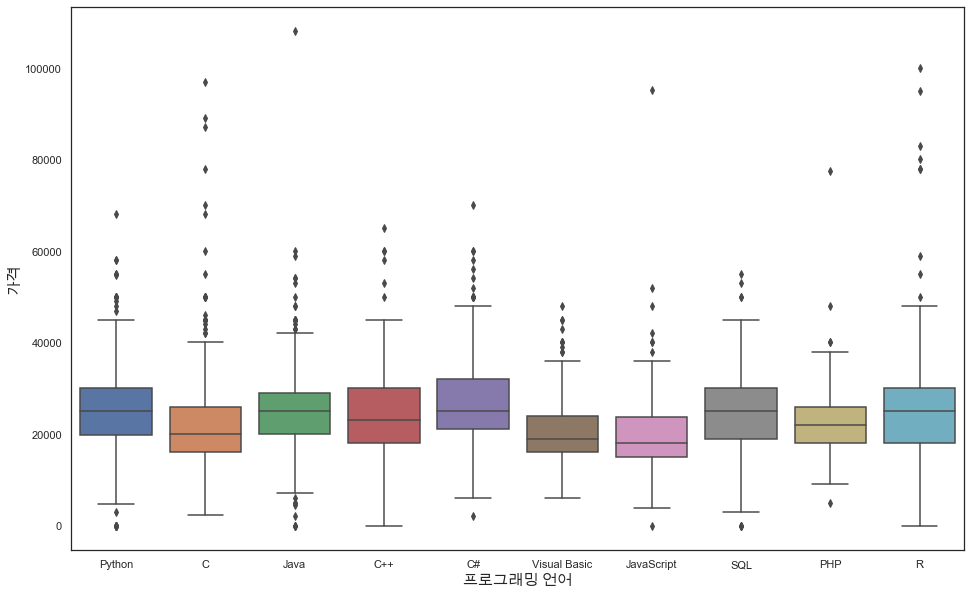

In [69]:
plt.figure(figsize=(16,10))
sns.set(font="Arial Unicode Ms", rc={"axes.unicode_minus":False}, style="white")
sns.set_color_codes("pastel")
sns.boxplot(x='language', y='price', data=book_df)
plt.ylabel('가격', fontsize=15)
plt.xlabel('프로그래밍 언어', fontsize=15)
plt.show()

- C와 R 언어에 outlier가 있어 보이므로, 가격순으로 top5 책만 확인해 보도록 한다.

In [58]:
book_df.sort_values('price', ascending=False).head()

,title,author,price,publisher,isbn,pubdate,keyword,link,year,language,page_num
1227,국민안전 SOC 디지털화 기술동향 (C-ITS/디지털트윈/수자원/재난대응),R&D정보센터,380000.0,지식산업정보원,115862154X,20201005,C,http://book.naver.com/bookdb/book_detail.php?b...,2020,C,624
4218,SEMICONDUCTOR Equipments (Concepts and Applica...,Manabu Tsujimura,195000.0,comebook,8995740221,20090623,R,http://book.naver.com/bookdb/book_detail.php?b...,2009,R,189
4311,R D OUTSOURCING 실무매뉴얼,편집부,150000.0,전략기술경영연구원,898986125X,20040427,R,http://book.naver.com/bookdb/book_detail.php?b...,2004,R,260
4241,Japan House R- (가 ie),이꼴북스 편집부,120000.0,이꼴북스,8997603175,20131001,R,http://book.naver.com/bookdb/book_detail.php?b...,2013,R,805
2077,"스프링과 JPA를 활용한 자바 엔터프라이즈 애플리케이션 개발 세트 (전3권,자바 O...",김영한|이일민,108000.0,에이콘출판,8960777447,20150731,자바,http://book.naver.com/bookdb/book_detail.php?b...,2015,Java,2456


 - 제목으로만 보아도 탑4 가격의 책은 프로그래밍 언어와는 상관 없는 책으로 생각되어 삭제하기로 한다.

In [59]:
book_df = book_df.drop(labels=[1227, 4218, 4311, 4241], axis=0).reset_index(drop=True)

- 이번에는 page_num으로 outlier 확인을 간단히 해본다

In [60]:
book_df.sort_values('page_num', ascending=False).head(10)

,title,author,price,publisher,isbn,pubdate,keyword,link,year,language,page_num
1258,"기업 업무 대백과 C세트 (비즈니스 성취의 지름길, 전8권)",현대경영연구소,70000.0,승산서관,8985042882,20131010,C,http://book.naver.com/bookdb/book_detail.php?b...,2013,C,2858
2076,"스프링과 JPA를 활용한 자바 엔터프라이즈 애플리케이션 개발 세트 (전3권,자바 O...",김영한|이일민,108000.0,에이콘출판,8960777447,20150731,자바,http://book.naver.com/bookdb/book_detail.php?b...,2015,Java,2456
2364,VISUAL C++ PROGRAMMING BIBLE VER. 6.X,이상엽,45000.0,영진닷컴,8931410425,19981120,C++,http://book.naver.com/bookdb/book_detail.php?b...,1998,C++,2248
1180,"동의보감 2 (외형편(C형),C형)",허준,45000.0,휴머니스트,8989899281,20080310,C,http://book.naver.com/bookdb/book_detail.php?b...,2008,C,2160
1142,"동의보감 1권-C형 (내경편, C형)",허준,38000.0,휴머니스트,8989899273,20020827,C,http://book.naver.com/bookdb/book_detail.php?b...,2002,C,1992
2804,Professional ASP.NET 4 in C# and VB (한국어판),Bill Evjen|Scott Hanselman|Devin Rader,56000.0,지앤선,8993827451,20120330,C#,http://book.naver.com/bookdb/book_detail.php?b...,2012,C#,1880
2469,혼자연구하는 C/C++ (제2권C++문법편),김상형,25000.0,맥스플러스원,8995692928,20060102,C++,http://book.naver.com/bookdb/book_detail.php?b...,2006,C++,1831
1073,C++ 기초 플러스,Stephen Prata,40000.0,성안당,8931555350,20200325,C,http://book.naver.com/bookdb/book_detail.php?b...,2020,C,1732
1626,JAVA HOW TO PROGRAM (자바 하우 투 프로그램),하비 디텔 폴 디텔,53000.0,케이앤피IT,8993425876,20090701,Java,http://book.naver.com/bookdb/book_detail.php?b...,2009,Java,1731
2807,C# 언어.프로그래밍 바이블 (초절정 고수로 가는),김명렬|정영식,70000.0,홍릉과학출판사,8972837911,20120125,C#,http://book.naver.com/bookdb/book_detail.php?b...,2012,C#,1730


In [61]:
# 1258, 1180, 1142 책은 프로그래밍 언어와 연관 없는 책으로 판단되어 삭제하기로 한다.

book_df = book_df.drop(labels=[1258, 1180, 1142], axis=0).reset_index(drop=True)

In [62]:
# 작업이 다 끝났으므로, 다시 한번 csv저장
book_df.to_csv('./try_3.csv', encoding='utf-8-sig', index=False)

In [63]:
len(book_df)

4349

In [66]:
book_df = pd.read_csv('./try_3.csv', encoding='utf-8-sig')

In [67]:
by_language = book_df.groupby(['language']).agg({
                                                'title':'count',
                                                'price':'mean'})

by_language = by_language.reset_index()
by_language = by_language.sort_values(['title'], ascending=False).reset_index(drop=True)
by_language

,language,title,price
0,C,906,22131.823204
1,Java,881,24736.662883
2,Python,573,24664.048866
3,R,508,24787.007874
4,SQL,359,25033.147632
5,Visual Basic,329,20205.471125
6,C++,275,25037.956204
7,C#,219,27411.872146
8,PHP,158,23156.962025
9,JavaScript,141,20386.524823


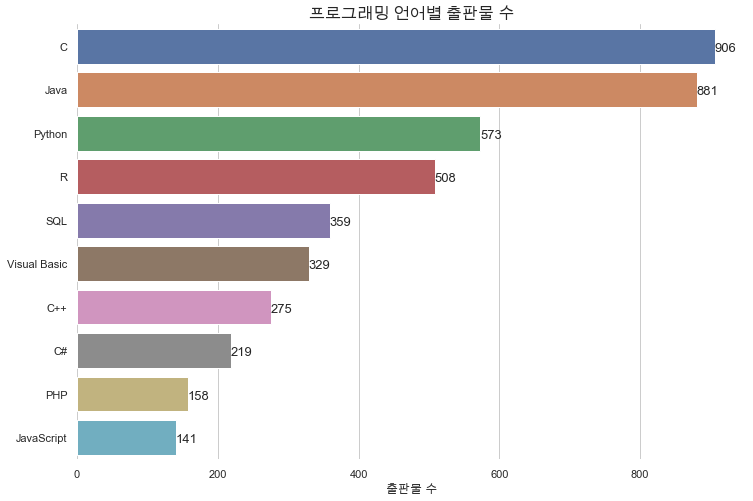

In [70]:
plt.figure(figsize=(12,8))
sns.set(font="Arial Unicode Ms", rc={"axes.unicode_minus":False}, style="white")
sns.set_color_codes("pastel")
plots = sns.barplot(data = by_language, x='title', y='language')
for bar in plots.patches:
    width = bar.get_width()
    plt.text(15+width, bar.get_y()+0.55*bar.get_height(), '{:.0f}'.format(width), ha='center', va='center', size=13)
plt.title('프로그래밍 언어별 출판물 수', fontsize=16)
plt.xlabel('출판물 수', fontsize=12)
plt.ylabel("")
plt.grid(axis='x')
sns.despine(left=True, bottom=True)
plt.show()

- C에 관한 출판물이 가장 많아 보이고, 그 다음으로 Java와 Python이 이어진다
- 물론 C가 오래전 부터 존재했고, 지금도 랭킹에서 2번째를 유지할 정도로 많이 쓰이는 언어긴 하지만,  분석에 사용하는 데이터를 불러오는 과정에서 "C"라는 단어가 들어가고 세부사항만 충족하면 정보가 크롤링 되었다.
- 그러므로 상대적으로 C에 관한 책 카운트 중에서 실제로 프로그래밍과 무관한 책도 다수 포함 되어 있을 것이라 추측하고 분석을 진행한다.

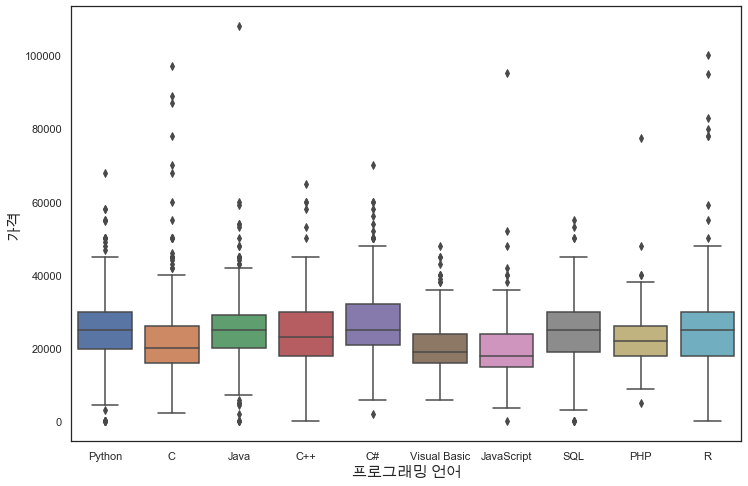

In [71]:
plt.figure(figsize=(12,8))
sns.set(font="Arial Unicode MS", rc={"axes.unicode_minus":False}, style="white")
sns.set_color_codes("pastel")
sns.boxplot(x='language', y='price', data=book_df)
plt.ylabel('가격', fontsize=15)
plt.xlabel('프로그래밍 언어', fontsize=15)
plt.show()

- TIOBE Top5 언어인 Python, C, Java, C++, C#에 관한 책들이 비교적 비슷한 가격대를 형성하는 형태를 보여주고 있다.
- TIOBE Top5에 포함되지는 않지만, 특정 분야에서 상대적으로 많이 사용되는 SQL이나 R 또한 Top5와 비슷한 가격대와 분포를 보여주고 있다.

In [72]:
by_language_year = book_df.groupby(['language', 'year']).agg({
                                                'title':'count',
                                                'price':'mean'})

by_language_year = by_language_year.reset_index()

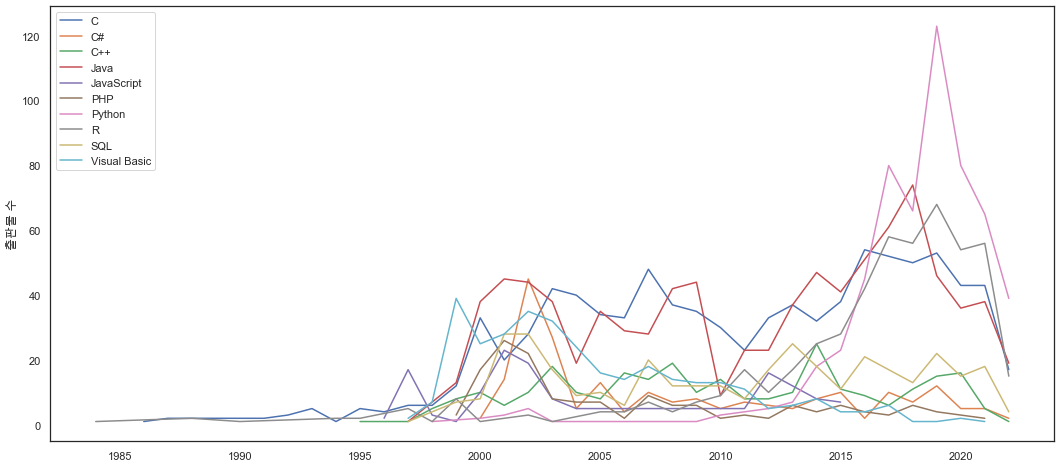

In [74]:
plt.figure(figsize=(18,8))
sns.lineplot(data=by_language_year, x='year', hue='language', y='title')
plt.ylabel("출판물 수")
plt.xlabel("")
plt.legend()
plt.show()

- 탑10 언어만 연도별로 출판물 수를 시각화해본 결과, Python은 2015년부터 급격하게 책 수가 증가한 것을 확인할 수 있었다.
- C와 Java의 경우 오랫동안 출판물 수를 꾸준하게 유지한 것으로 보인다.
R의 경우 Python과 비슷하게 2010년대에 들어 출판물 수가 많아진 것으로 보인다.


## 4. 출판사 순위 시각화

In [75]:
by_publisher = book_df.groupby(['publisher']).agg({
                                                'title':'count',
                                                'price':'mean'})

by_publisher = by_publisher.reset_index()
by_publisher = by_publisher.sort_values(['title'], ascending=False).reset_index(drop=True)
by_publisher

,publisher,title,price
0,한빛미디어,332,25735.843373
1,에이콘출판,249,33316.465863
2,정보문화사,202,25594.059406
3,Packt(GCOScience),167,20766.467066
4,영진닷컴,160,22114.375000
...,...,...,...
510,에듀박스,1,18000.000000
511,어포스트,1,19500.000000
512,어람출판사,1,20000.000000
513,남두도서,1,24000.000000


In [76]:
len(by_publisher[by_publisher['title']==1])

244

In [77]:
# 절반 가량의 출판사가 1권의 책밖에 내지 않았기에 516 출판사 모두를 순위대로 나열하는 것은 무의미해 보이므로 탑10만 확인.
by_publisher_top10 = by_publisher[:10]

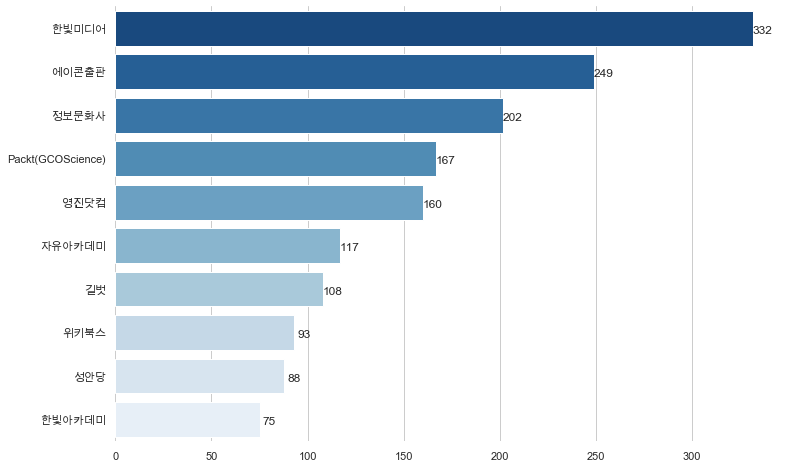

In [78]:
plt.figure(figsize=(12,8))
sns.set(font="Arial Unicode MS", rc={"axes.unicode_minus":False}, style="white")
sns.set_color_codes("pastel")
plots = sns.barplot(data = by_publisher_top10, x='title', y='publisher', palette = "Blues_r")
for bar in plots.patches:
    width = bar.get_width()
    plt.text(5+width, bar.get_y()+0.55*bar.get_height(), '{:.0f}'.format(width), ha='center', va='center', size=12)
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.grid(axis='x')
sns.despine(left=True, bottom=True)
plt.show()


In [79]:
by_publisher_top10['title'].sum(), round(by_publisher_top10['title'].sum()/len(book_df), 3)

(1591, 0.366)

- Top10 출판사의 출판수가 총 1590개로 전체 데이터의 37%정도를 차지한다.
- 그 중에서 한빛미디어, 에이콘출판과 정보문화사에서 가장 많이 출판하였다.

In [80]:

book_df[book_df['publisher'] == '한빛미디어']['title'].count()

332

In [81]:
pub1_df = book_df[book_df['publisher'] == '한빛미디어'].groupby('language')['title'].count().reset_index()
pub2_df = book_df[book_df['publisher'] == '에이콘출판'].groupby('language')['title'].count().reset_index()

In [84]:
pub1_df

,language,title
0,C,47
1,C#,19
2,C++,21
3,Java,107
4,JavaScript,12
5,PHP,12
6,Python,62
7,R,8
8,SQL,39
9,Visual Basic,5


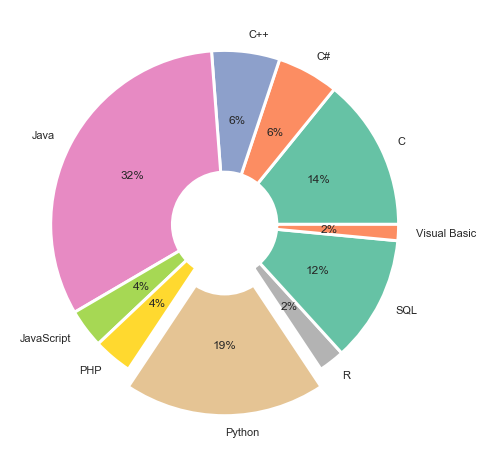

In [91]:
plt.figure(figsize=(12,8))
sns.set_palette("Set2")
plt.pie(pub1_df['title'], labels = pub1_df['language'], autopct='%.0f%%', explode=[0, 0, 0, 0, 0, 0, 0.1, 0, 0, 0], wedgeprops={'width':0.7, 'edgecolor':'w', 'linewidth':3})
plt.show()

- 한빛출판사의 언어별 출판물을 비교하여 보니, 지금까지 봐왔던 패턴과 같이 Java, Python, C언어가 상위권을 차지하고 있다.

In [92]:
pub2_df

,language,title
0,C,35
1,C#,15
2,C++,17
3,Java,63
4,JavaScript,6
5,PHP,3
6,Python,61
7,R,43
8,SQL,6


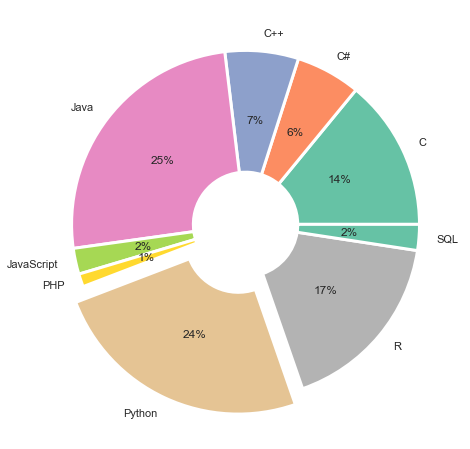

In [93]:
plt.figure(figsize=(12,8))
sns.set_palette("Set2")
plt.pie(pub2_df['title'], labels = pub2_df['language'], autopct='%.0f%%', explode=[0, 0, 0, 0, 0, 0, 0.1, 0, 0], wedgeprops={'width':0.7, 'edgecolor':'w', 'linewidth':3})
plt.show()

- 에이콘 출판 또한 Python, Java, C를 top3로 두고있으며, R이 비슷한 비율로 4번째를 자리하고있다.

## 5. 최근 2년 출판물과 그 전 3년의 출판물 비교

In [94]:
book_year = book_df[book_df['year'] > 2016]

In [95]:
book_year['category'] = np.where(book_year['year'] > 2019, "Recent", "Older")

/var/folders/1v/l58j125s3l3_f2vgrjx8n4000000gn/T/ipykernel_48782/1308727618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_year['category'] = np.where(book_year['year'] > 2019, "Recent", "Older")


In [96]:
book_year['category'].value_counts()

Older     921
Recent    584
Name: category, dtype: int64

- Older 캐터고리에는 2017, 2018, 2019 연도가 포함되어 있으므로 Recent 보다는 더 많이 출판되었을 것이라 예상 하였다.
- 그렇지만 두 캐터고리의 차이는 1년 정도밖에 되지 않으므로, 상대적으로 출판 수의 차이가 더 커보인다.

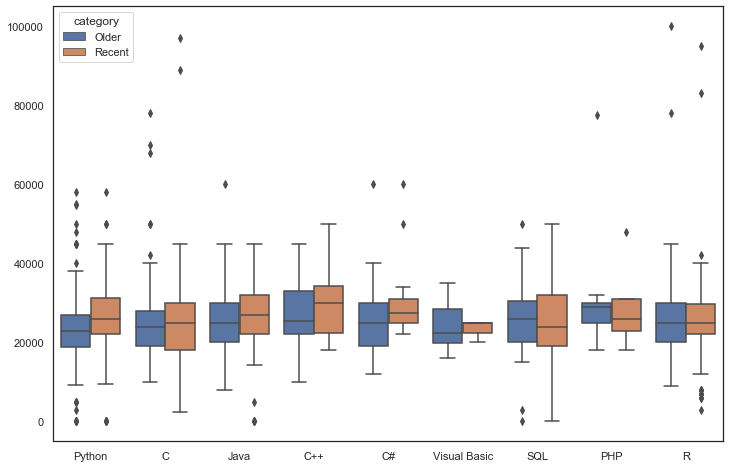

In [98]:
plt.figure(figsize=(12,8))
sns.set(font="Arial Unicode MS", rc={"axes.unicode_minus":False}, style="white")
sns.set_color_codes("pastel")
sns.boxplot(x='language', y='price', hue = 'category', data=book_year)
# plt.title("최근 2년과 그 전의 3년 가격 비교", fontsize=20)
plt.ylabel("")
plt.xlabel("")
plt.show()

- 최근에 들어 가격 면에서는 대체로 모든 언어의 책이 다소 비싸진 것으로 판단된다.
- 예외로는 SQL과 PHP가 있다.

In [99]:
book_year['language'].describe()


count       1505
unique         9
top       Python
freq         453
Name: language, dtype: object

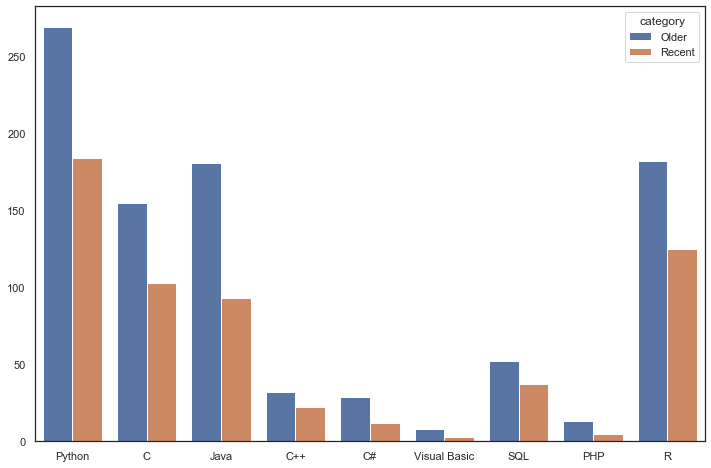

In [100]:
plt.subplots(figsize=(12,8))
sns.set(font="Arial Unicode MS", rc={"axes.unicode_minus":False}, style="white")
sns.set_color_codes("pastel")
sns.countplot(x='language', data=book_year, hue='category')
# plt.title("최근 2년과 그 전의 3년 출판 수 비교", fontsize=20)
plt.ylabel("")
plt.xlabel("")
plt.show()

- 최근에 들어 모든 언어에서 출판물 수가 줄어든 것으로 확인된다.
- Pyhton, C, Java, R언어의 출판 수가 최근과 예전 변함없이 가장 많다.
- TIOBE 순위와 비교하였을 때, Python, C, Java는 탑3를 차지하고 있으며 인기에 따라서 책 출판또한 많이 된 것으로 추측된다
- 반면에 SQL과 R의 경우에는 TIOBE 랭킹에서는 다소 떨어지지만 앞서서 언급했듯이 각 분야에 좀 더 특화된 언어이므로 출판 수 또한 랭킹에 상관없이 유지되고 있는 형상으로 추측된다.

In [101]:
book_year.head(3)

,title,author,price,publisher,isbn,pubdate,keyword,link,year,language,page_num,category
20,초보자를 위한 파이썬 200제 (Python),장삼용,20000.0,정보문화사,8956747342,20170227,Python,http://book.naver.com/bookdb/book_detail.php?b...,2017,Python,376,Older
21,"파이썬 (Python,다양한 예제로 배우는 완전 쉬운)",박병기,23000.0,아티오,8998955954,20170130,Python,http://book.naver.com/bookdb/book_detail.php?b...,2017,Python,420,Older
23,"씽크 파이썬 (컴퓨터 과학자처럼 생각하며 배우는 파이썬,Think Python)",앨런 다우니,22000.0,길벗,1160502862,20171012,Python,http://book.naver.com/bookdb/book_detail.php?b...,2017,Python,360,Older


In [102]:
by_category = book_year.groupby(['category', 'language']).agg({
                                                'title':'count',
                                                'price':'mean'}).reset_index()


In [103]:
by_category.head()

,category,language,title,price
0,Older,C,155,24871.612903
1,Older,C#,29,26593.103448
2,Older,C++,32,27218.750000
3,Older,Java,181,24939.779006
4,Older,PHP,13,30723.076923


In [104]:
by_category_pct = by_category.copy()

In [105]:
for idx, row in by_category_pct.iterrows():
    if row['category'] == 'Older':
        by_category_pct.loc[idx, 'count_per_year'] = round(int(row['title']) / 3,1)
    else:
        by_category_pct.loc[idx, 'count_per_year'] = round(int(row['title']) / 3,1)

In [106]:
by_category_pct

,category,language,title,price,count_per_year
0,Older,C,155,24871.612903,51.7
1,Older,C#,29,26593.103448,9.7
2,Older,C++,32,27218.750000,10.7
3,Older,Java,181,24939.779006,60.3
4,Older,PHP,13,30723.076923,4.3
5,Older,Python,269,23166.171004,89.7
6,Older,R,182,25937.912088,60.7
7,Older,SQL,52,25511.538462,17.3
8,Older,Visual Basic,8,24125.000000,2.7
9,Recent,C,103,24782.524272,34.3


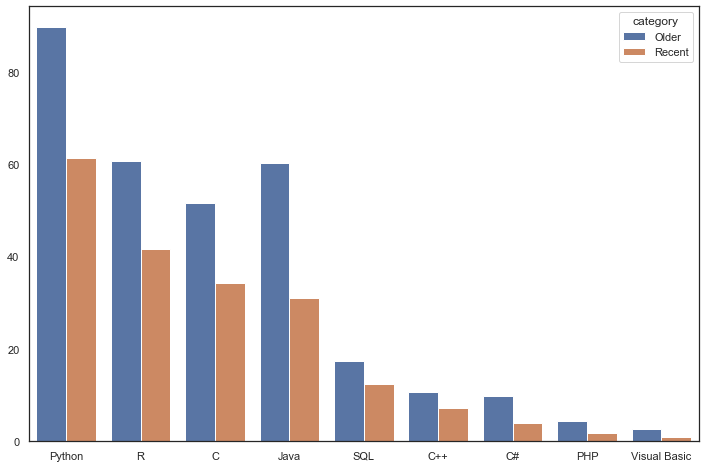

In [107]:
plt.subplots(figsize=(12,8))
sns.set(font="Arial Unicode MS", rc={"axes.unicode_minus":False}, style="white")
sns.set_color_codes("pastel")
sns.barplot(x='language', data=by_category_pct, hue='category', y='count_per_year', order=by_category_pct[by_category_pct['category']=='Recent'].sort_values('count_per_year', ascending=False)['language'])
# plt.title("최근 2년과 그 전의 3년 출판 수 비교", fontsize=20)
plt.ylabel("")
plt.xlabel("")
plt.show()

In [108]:
period_year = book_year.groupby(['language', 'year']).agg({
                                                'title':'count',
                                                'price':'mean'})

period_year = period_year.reset_index()


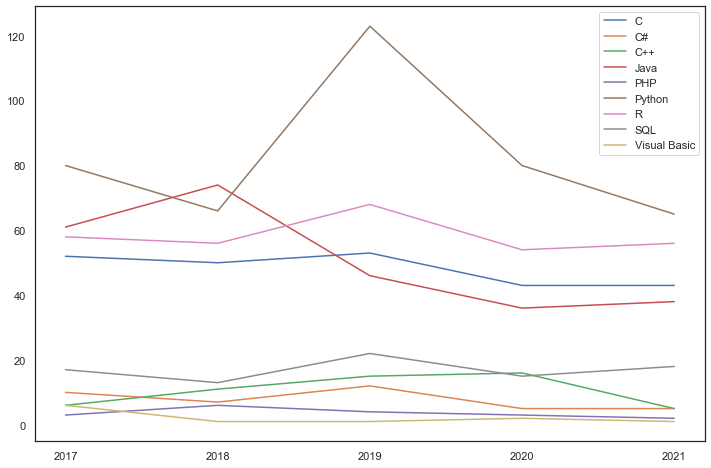

In [109]:
plt.figure(figsize=(12,8))
ax = sns.lineplot(data=period_year[period_year['year']<=2021], x=period_year.year, hue='language', y='title')
plt.ylabel("")
plt.xlabel("")
plt.xticks([2017, 2018, 2019, 2020, 2021])
plt.legend()

# for line, name in zip(ax.lines, period_year.language):
#     y = line.get_ydata()[-1]
#     ax.annotate(name, xy=(1,y), xytext=(6,0), color=line.get_color(), 
#                 xycoords = ax.get_yaxis_transform(), textcoords="offset points",
#                 size=14, va="center")

plt.show()


In [110]:
pub1_line = book_df[book_df['publisher'] == '한빛미디어'].groupby(['language', 'year']).agg({
                                                'title':'count',
                                                'price':'mean'})

pub1_line = pub1_line.reset_index()

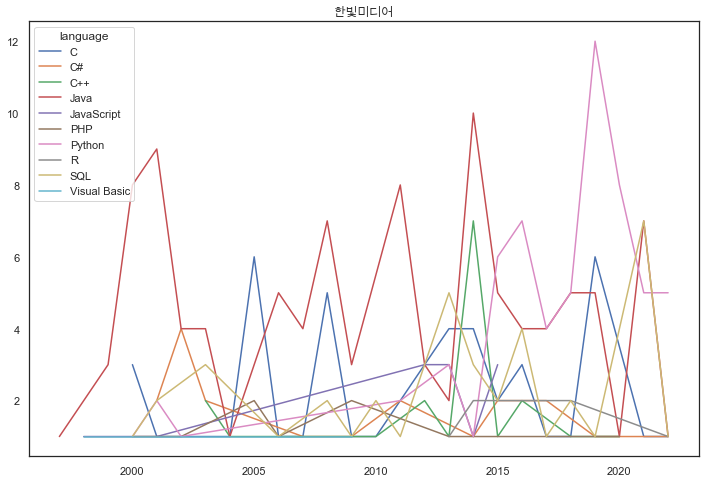

In [111]:
plt.figure(figsize=(12,8))
sns.lineplot(data=pub1_line, x='year', y='title', hue='language')
plt.ylabel("")
plt.xlabel("")
plt.title("한빛미디어", fontsize=12)
plt.show()

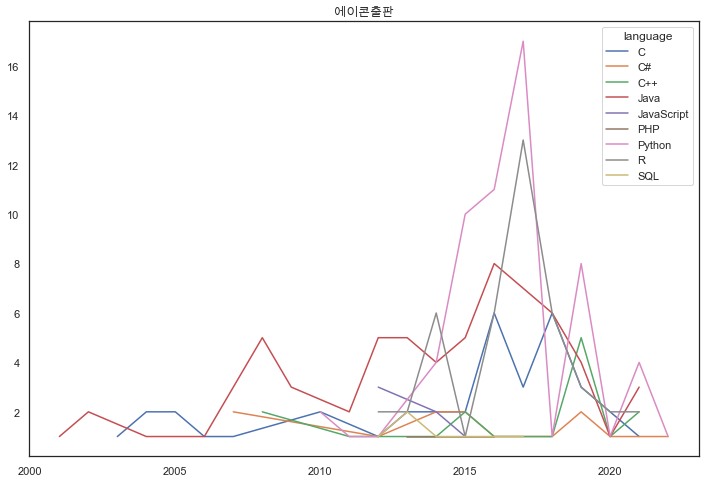

In [113]:
pub2_line = book_df[book_df['publisher'] == '에이콘출판'].groupby(['language', 'year']).agg({
                                                'title':'count',
                                                'price':'mean'})

pub2_line = pub2_line.reset_index()

plt.figure(figsize=(12,8))
sns.lineplot(data=pub2_line, x='year', y='title', hue='language')
plt.ylabel("")
plt.xlabel("")
plt.title("에이콘출판", fontsize=12)
plt.show()

In [114]:
def label_point(x, y, val):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        plt.text(point['x']+150, point['y'], str(point['val']))

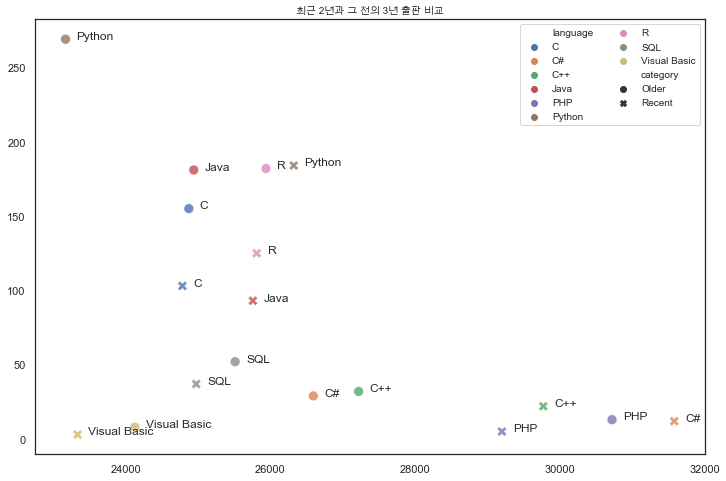

In [116]:
plt.figure(figsize=(12,8))

sns.scatterplot(x="price", y='title', hue='language', style="category", data=by_category, s=100, alpha=0.8)
plt.title("최근 2년과 그 전의 3년 출판 비교", fontsize=10)
plt.legend(loc="upper right", ncol=2, fontsize=10)

label_point(by_category.price, by_category.title, by_category.language)

plt.xlabel("")
plt.ylabel("")

plt.show()

- 각 언어마다 총 출판 수와 평균 가격을 최근과 예전을 비교해본 결과 위와 같은 scatterplot 이 그려진다.
- 대체로 평균 가격이 최근에 들어 올라간 것으로 확인된다 (최근은 'X' 마커 사용)
- 총 출판 수 차이로는 Python, R, Java, C언어가 상대적으로 많이 줄어든 것으로 확인된다.

# 6. 전체보기

### 6.1 네이버 API 이용해서 정보 긁어오기

In [117]:
# 네이버 API 상세검색에서 연도를 지정해줄 범위와 키워드 설정
keywords_2 = ['Assembly language', 'Classic Visual Basic', 'Go 언어', 'MATLAB', 'Groovy', 'Groovy 언어', 'Ruby', 'Ruby 언어', 'Swift', 'Swift 언어', 'Fortran', 'Fortran 언어', 'Perl', 'Perl 언어', 'Delphi/Object Pascal']

In [118]:
book_part2_df = pd.DataFrame()

In [119]:
# 반복문을 돌려 각 검색어의 책 정보를 불러모아 book_part2_df에 저장
for query in keywords_2:
    for cat in category:    
        for i in range(6):
            start = years_start[i]
            end = years_end[i]
            for n in range(1, 1000, 100):
                url = get_url(query, n, 100, start, end, cat)
                one_result = get_result_onpage(url)
                tmp_df = get_info(one_result, query)

            book_part2_df = pd.concat([book_part2_df, tmp_df], ignore_index=True)
            time.sleep(0.5)

[2022-06-29 11:37:59.976166] Url Request Success
[2022-06-29 11:38:00.052264] Url Request Success
[2022-06-29 11:38:00.119195] Url Request Success
[2022-06-29 11:38:00.206157] Url Request Success
[2022-06-29 11:38:00.270170] Url Request Success
[2022-06-29 11:38:00.334848] Url Request Success
[2022-06-29 11:38:00.395154] Url Request Success
[2022-06-29 11:38:00.460230] Url Request Success
[2022-06-29 11:38:00.529355] Url Request Success
[2022-06-29 11:38:00.596797] Url Request Success
[2022-06-29 11:38:01.186580] Url Request Success
[2022-06-29 11:38:01.274909] Url Request Success
[2022-06-29 11:38:01.351384] Url Request Success
[2022-06-29 11:38:01.425936] Url Request Success
[2022-06-29 11:38:01.485292] Url Request Success
[2022-06-29 11:38:01.561083] Url Request Success
[2022-06-29 11:38:01.626085] Url Request Success
[2022-06-29 11:38:01.695450] Url Request Success
[2022-06-29 11:38:01.761970] Url Request Success
[2022-06-29 11:38:01.826547] Url Request Success
[2022-06-29 11:38:02

## 6.2 데이터 처리

In [120]:
# isbn 
duplicates = book_part2_df.duplicated(['isbn'])
duplicates.value_counts()

False    515
True      76
dtype: int64

In [121]:
# 중복 데이터 제거
book_part2_df = book_part2_df.drop_duplicates(['isbn'], keep = 'first').reset_index(drop=True)

In [122]:
# isbn 값이 없는 행을 조회해본 결과, 존재하지 않음을 확인하였음.
book_part2_df[book_part2_df['isbn'].isna()]

,title,author,price,publisher,isbn,pubdate,keyword,link


In [123]:
# 가격 데이터 null 값 조회
book_part2_df[book_part2_df['price'].isna()]

,title,author,price,publisher,isbn,pubdate,keyword,link


In [124]:
book_part2_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      515 non-null    object
 1   author     515 non-null    object
 2   price      515 non-null    object
 3   publisher  515 non-null    object
 4   isbn       515 non-null    object
 5   pubdate    515 non-null    object
 6   keyword    515 non-null    object
 7   link       515 non-null    object
dtypes: object(8)
memory usage: 32.3+ KB


In [125]:
# 일단 csv로 저장
book_part2_df.to_csv('./part2_try_1.csv', encoding='utf-8-sig', index=False)

In [126]:
book_part2_df = pd.read_csv('./part2_try_1.csv', encoding='utf-8-sig')

In [127]:
# pubdate 컬럼의 첫 4개만 들고와서 year로 지정.
book_part2_df['year'] = book_part2_df['pubdate'].astype(str).str[:4].astype(int)

In [128]:
# price null값 확인
book_part2_df.loc[book_df['price'] == '']

,title,author,price,publisher,isbn,pubdate,keyword,link,year


In [129]:
# isbn null값 확인
book_part2_df.loc[book_df['isbn'] == '']

,title,author,price,publisher,isbn,pubdate,keyword,link,year


In [130]:
book_part2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      515 non-null    object
 1   author     514 non-null    object
 2   price      515 non-null    int64 
 3   publisher  515 non-null    object
 4   isbn       515 non-null    object
 5   pubdate    515 non-null    int64 
 6   keyword    515 non-null    object
 7   link       515 non-null    object
 8   year       515 non-null    int64 
dtypes: int64(3), object(6)
memory usage: 36.3+ KB


In [131]:
# language 컬럼 추가
book_part2_df['language'] = book_part2_df['keyword']

In [132]:
# 각 키워드를 Language 컬럼에 언어 이름으로
for index, row in book_part2_df.iterrows():
    if "Go 언어" in row['keyword']:
        book_part2_df.loc[index, 'language'] = "Go"
    elif "Ruby 언어" in row['keyword']:
        book_part2_df.loc[index, 'language'] = "Ruby"
    elif "Fortran 언어" in row['keyword']:
        book_part2_df.loc[index, 'language'] = "Fortran"
    elif "Perl 언어" in row['keyword']:
        book_part2_df.loc[index, 'language'] = "Perl"


In [133]:
book_part2_df['language'].value_counts()

MATLAB               321
Fortran              110
Swift                 29
Perl                  27
Go                    14
Ruby                  11
Assembly language      3
Name: language, dtype: int64

In [134]:
# 페이지 수 추가

for i in range(len(book_part2_df)):
    url = book_part2_df['link'][i]
    response = urlopen(url)
    page = BeautifulSoup(response, 'html.parser')
    
    # Ebook의 경우에는 페이지 수가 존재하지 않는 경우도 있는것으로 판단된다.
    try:   
        tmp = page.find_all(class_= "book_info")[0].get_text()
        page_num = re.search("페이지\s+\d+", tmp).group().split()[1]
        
        book_part2_df.loc[i, 'page_num'] = page_num
        print(i, page_num, url)

    except:
        print("======  ", i, "  ======", url)

0 448 http://book.naver.com/bookdb/book_detail.php?bid=206014
1 752 http://book.naver.com/bookdb/book_detail.php?bid=3658966
2 752 http://book.naver.com/bookdb/book_detail.php?bid=2133212
3 504 http://book.naver.com/bookdb/book_detail.php?bid=3556675
4 488 http://book.naver.com/bookdb/book_detail.php?bid=9102978
5 146 http://book.naver.com/bookdb/book_detail.php?bid=9923469
6 296 http://book.naver.com/bookdb/book_detail.php?bid=10680229
7 516 http://book.naver.com/bookdb/book_detail.php?bid=12308125
8 280 http://book.naver.com/bookdb/book_detail.php?bid=12308784
9 428 http://book.naver.com/bookdb/book_detail.php?bid=10406887
10 324 http://book.naver.com/bookdb/book_detail.php?bid=10337667
11 488 http://book.naver.com/bookdb/book_detail.php?bid=12845795
12 460 http://book.naver.com/bookdb/book_detail.php?bid=13786841
13 384 http://book.naver.com/bookdb/book_detail.php?bid=14468474
14 422 http://book.naver.com/bookdb/book_detail.php?bid=14050528
15 744 http://book.naver.com/bookdb/book_d

In [135]:
book_part2_df[book_part2_df['page_num'].isna()]

,title,author,price,publisher,isbn,pubdate,keyword,link,year,language,page_num
66,매트랩시작하기(MATLAB5),김우식,15000,인터비젼,8988066634,20000802,MATLAB,http://book.naver.com/bookdb/book_detail.php?b...,2000,MATLAB,NaN
338,프로그래밍 루비 (Programming Ruby),Andy Hunt|Dave Thomas|Chad Fowler,39000,인사이트,8991268250,20070101,Ruby,http://book.naver.com/bookdb/book_detail.php?b...,2007,Ruby,NaN
344,"Objective C, Ruby를 만나다",박창진,5000,유페이퍼,1163043850,20170204,Ruby,http://book.naver.com/bookdb/book_detail.php?b...,2017,Ruby,NaN
345,"Visual C#, Ruby를 만나다",박창진,5000,유페이퍼,1163045993,20170107,Ruby,http://book.naver.com/bookdb/book_detail.php?b...,2017,Ruby,NaN
510,MASTERING PERL 5,Herrmann,48000,에이콘출판,6000003710,19991009,Perl,http://book.naver.com/bookdb/book_detail.php?b...,1999,Perl,NaN


In [137]:
book_part2_df = book_part2_df.dropna(subset="page_num").reset_index(drop=True)

In [138]:
book_part2_df[book_part2_df['page_num'].isna()]

,title,author,price,publisher,isbn,pubdate,keyword,link,year,language,page_num


In [139]:
book_part2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      510 non-null    object
 1   author     509 non-null    object
 2   price      510 non-null    int64 
 3   publisher  510 non-null    object
 4   isbn       510 non-null    object
 5   pubdate    510 non-null    int64 
 6   keyword    510 non-null    object
 7   link       510 non-null    object
 8   year       510 non-null    int64 
 9   language   510 non-null    object
 10  page_num   510 non-null    object
dtypes: int64(3), object(8)
memory usage: 44.0+ KB


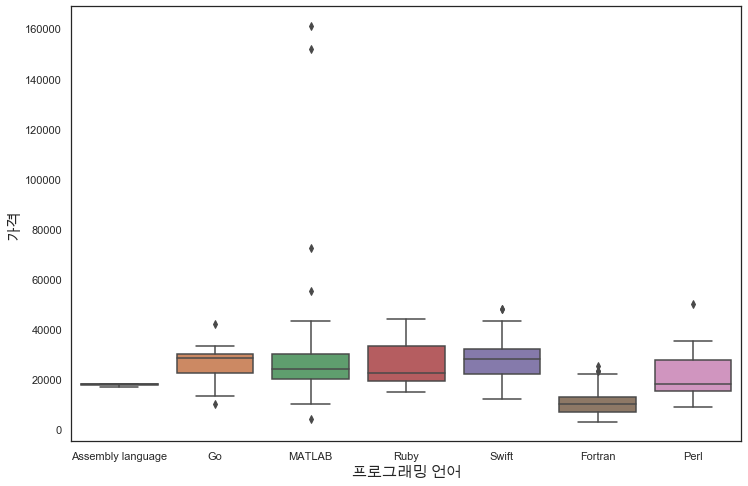

In [140]:
# Outlier Check

plt.figure(figsize=(12,8))
sns.set(font="Arial Unicode MS", rc={"axes.unicode_minus":False}, style="white")
sns.set_color_codes("pastel")
sns.boxplot(x='language', y='price', data=book_part2_df)
plt.ylabel('가격', fontsize=15)
plt.xlabel('프로그래밍 언어', fontsize=15)
plt.show()

In [141]:
book_part2_df.sort_values('price', ascending=False).head(3)

,title,author,price,publisher,isbn,pubdate,keyword,link,year,language,page_num
242,Explorations of Mathematical Models in Biology...,Mazen Shahin,161000,WILEY,1118032128,20140203,MATLAB,http://book.naver.com/bookdb/book_detail.php?b...,2014,MATLAB,256
121,CIRCUIT SYSTEMS WITH MATLAB AND PSPICE,양원영,151810,홍릉과학출판사,897283565X,20060901,MATLAB,http://book.naver.com/bookdb/book_detail.php?b...,2006,MATLAB,512
161,MATLAB & Simulink 입문 (R2015a),여영구,72500,아진,8957613838,20150720,MATLAB,http://book.naver.com/bookdb/book_detail.php?b...,2015,MATLAB,270


- outlier 조회한 결과, 모두 MATLAB에 관한 실제 도서임을 확인하여 제거하지 않기로 한다.

In [142]:
# 페이지 수로 outlier 찾아보기
book_part2_df.sort_values('page_num', ascending=False).head(10)

,title,author,price,publisher,isbn,pubdate,keyword,link,year,language,page_num
260,아날로그 및 디지털 통신이론 (MATLAB 실습과 함께 배우는),김명진,40000,생능출판,897050981X,20190621,MATLAB,http://book.naver.com/bookdb/book_detail.php?b...,2019,MATLAB,988
266,구조동역학 (MATLAB 코드 포함),김두기,38000,구미서관,1162571756,20210810,MATLAB,http://book.naver.com/bookdb/book_detail.php?b...,2021,MATLAB,981
317,MATLAB활용 강력한 데이터 시각화를 위한 멀티 플랫폼 도구,Micah Allen,20000,아진,8957616764,20200706,MATLAB,http://book.naver.com/bookdb/book_detail.php?b...,2020,MATLAB,98
191,25시간만에 배우는 머신러닝 예제 (MATLAB 활용),김준석|김상권|정다래|최용호|김성기|김영록,15000,이모션미디어,1188145991,20181130,MATLAB,http://book.naver.com/bookdb/book_detail.php?b...,2018,MATLAB,97
228,아날로그 및 디지털 통신이론 (MATLAB 실습과 함께 배우는),김명진,38000,생능출판사,8970505733,20070220,MATLAB,http://book.naver.com/bookdb/book_detail.php?b...,2007,MATLAB,962
493,PERL 5 (21일 완성),David Till,28000,성안당,8931545029,20010227,Perl,http://book.naver.com/bookdb/book_detail.php?b...,2001,Perl,950
267,최신 공정제어공학 (MATLAB의 활용과 실습),여영구,43000,사이플러스,118873122X,20210301,MATLAB,http://book.naver.com/bookdb/book_detail.php?b...,2021,MATLAB,948
91,MATLAB을 이용한 전력시스템 해석 1,김광원|현승호,4000,UUP,8978687814,20050215,MATLAB,http://book.naver.com/bookdb/book_detail.php?b...,2005,MATLAB,92
350,만들면서 배우는 Swift (스위프트로 시작하는 iOS 개발),야곰,11900,한빛미디어,8968487197,20141121,Swift,http://book.naver.com/bookdb/book_detail.php?b...,2014,Swift,92
367,꼼꼼한 재은 씨의 스위프트 기본편 (iOS 앱 개발을 위한 Swift 바이블 시리즈...,이재은,38000,루비페이퍼,1186710314,20180501,Swift,http://book.naver.com/bookdb/book_detail.php?b...,2018,Swift,908


In [143]:
# 작업이 다 끝났으므로, 다시 한번 csv저장
book_part2_df.to_csv('./part2_try_2.csv', encoding='utf-8-sig', index=False)

In [144]:
# 데이터 합치기

book_full = pd.concat([book_df, book_part2_df])

In [145]:
book_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4859 entries, 0 to 509
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      4859 non-null   object 
 1   author     4856 non-null   object 
 2   price      4857 non-null   float64
 3   publisher  4859 non-null   object 
 4   isbn       4859 non-null   object 
 5   pubdate    4859 non-null   int64  
 6   keyword    4859 non-null   object 
 7   link       4859 non-null   object 
 8   year       4859 non-null   int64  
 9   language   4859 non-null   object 
 10  page_num   4859 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 455.5+ KB


In [146]:
# 출판연도가 2000년 이상의 데이터만 포함시키기로 함

book_full = book_full[book_full['year'] >= 2000]

In [147]:
book_full = book_full.reset_index(drop=True)

In [148]:
book_full.head(3)

,title,author,price,publisher,isbn,pubdate,keyword,link,year,language,page_num
0,JUMP TO PYTHON,박응용,17000.0,정보게이트,8981611211,20010808,Python,http://book.naver.com/bookdb/book_detail.php?b...,2001,Python,454
1,PYTHON 포켓 레퍼런스,마크 루츠,4600.0,한빛미디어,897914086X,20001010,Python,http://book.naver.com/bookdb/book_detail.php?b...,2000,Python,106
2,PYTHON AND TKINTER PROGRAMMING,JOHN E.GRAYSON,28000.0,인포북,8980544243,20001101,Python,http://book.naver.com/bookdb/book_detail.php?b...,2000,Python,852


In [149]:
book_full.to_csv('./full_try_1.csv', encoding='utf-8-sig', index=False)

## 6.3 페이지 수 vs 가격

In [150]:
book_full = pd.read_csv('./full_try_1.csv', encoding='utf-8-sig')

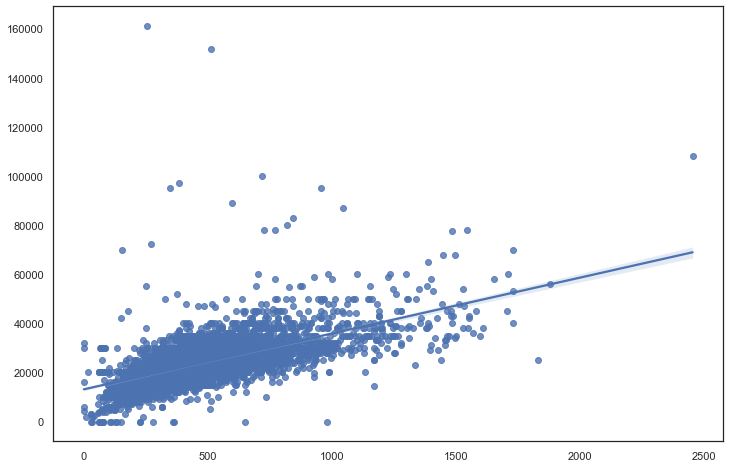

In [151]:
plt.figure(figsize=(12,8))
sns.regplot(x='page_num', y='price', data=book_full)
# plt.title('페이지수와 가격 상관관계', fontsize=16)
plt.xlabel("")
plt.ylabel("")

plt.show()

- 대체로 페이지 수의 증가에 따라서 가격도 증가하는 추세다.
- 예외로는 Ruby언어가 있어 보인다.
- 그리고, Python, Java, C++ 등의 언어가 비교적 높은 페이지수대비 가격 상승율을 보여주고 있다.

In [152]:
language_full = book_full.groupby(['language']).agg({
                                                'title':'count',
                                                'price':'mean'})

language_full = language_full.reset_index()
language_full = language_full.sort_values(['title'], ascending=False).reset_index(drop=True)
language_full

,language,title,price
0,Java,867,24758.938870
1,C,855,22641.920375
2,Python,572,24677.447552
3,R,486,25201.646091
4,SQL,351,24965.527066
5,MATLAB,295,25185.796610
6,Visual Basic,281,20075.800712
7,C++,260,25011.196911
8,C#,219,27411.872146
9,PHP,155,23295.483871


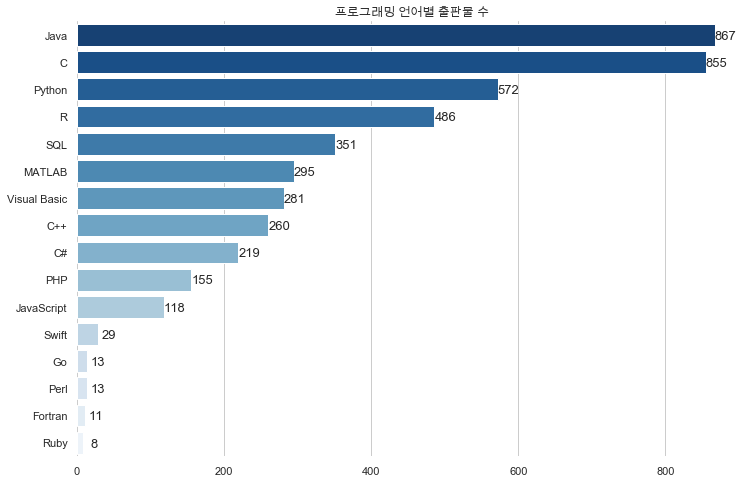

In [156]:
plt.figure(figsize=(12,8))
sns.set(font="Arial Unicode MS", rc={"axes.unicode_minus":False}, style="white")
sns.set_color_codes("pastel")
plots = sns.barplot(data = language_full, x='title', y='language', palette="Blues_r")
for bar in plots.patches:
    width = bar.get_width()
    plt.text(15+width, bar.get_y()+0.55*bar.get_height(), '{:.0f}'.format(width), ha='center', va='center', size=13)
plt.title('프로그래밍 언어별 출판물 수', fontsize=12)
plt.xlabel("")
plt.ylabel("")
plt.grid(axis='x')
sns.despine(left=True, bottom=True)
plt.show()


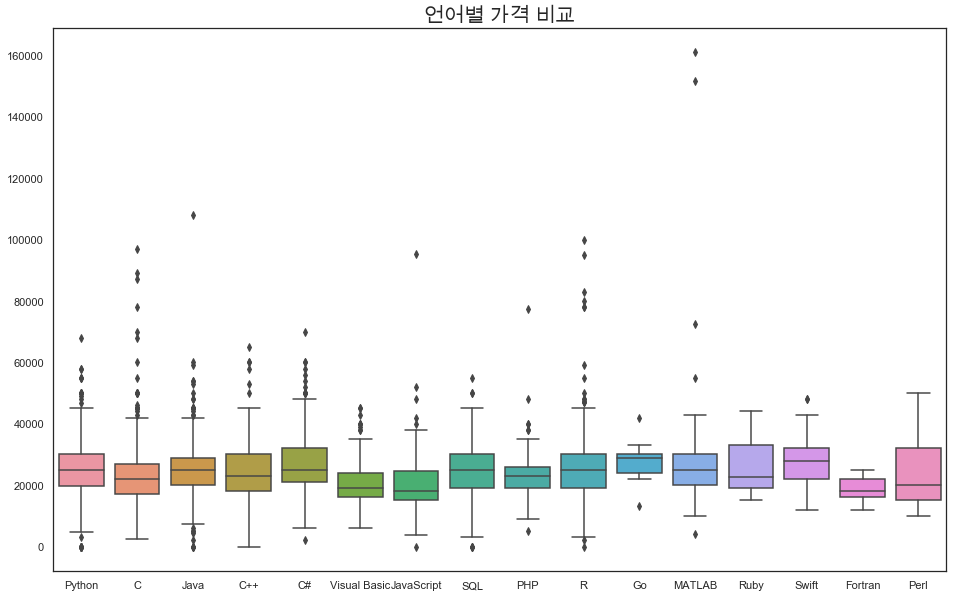

In [155]:
plt.figure(figsize=(16,10))
sns.set(font="Arial Unicode MS", rc={"axes.unicode_minus":False}, style="white")
sns.set_color_codes("pastel")
sns.boxplot(x='language', y='price', data=book_full)
plt.title("언어별 가격 비교", fontsize=20)
plt.ylabel('')
plt.xlabel('')
plt.show()

- 좀 더 대중적인 (Top10 + R)에 포함되어 있던 언어는 대체로 가격이 비슷하게 형성되어 있는 패턴을 볼 수 있다.
- 그에 비해 top11-20에 위치해 있던 언어는 조금 더 가격에 분포도 크고, top10의 평균과는 다르게 위치한 것을 볼 수 있다.

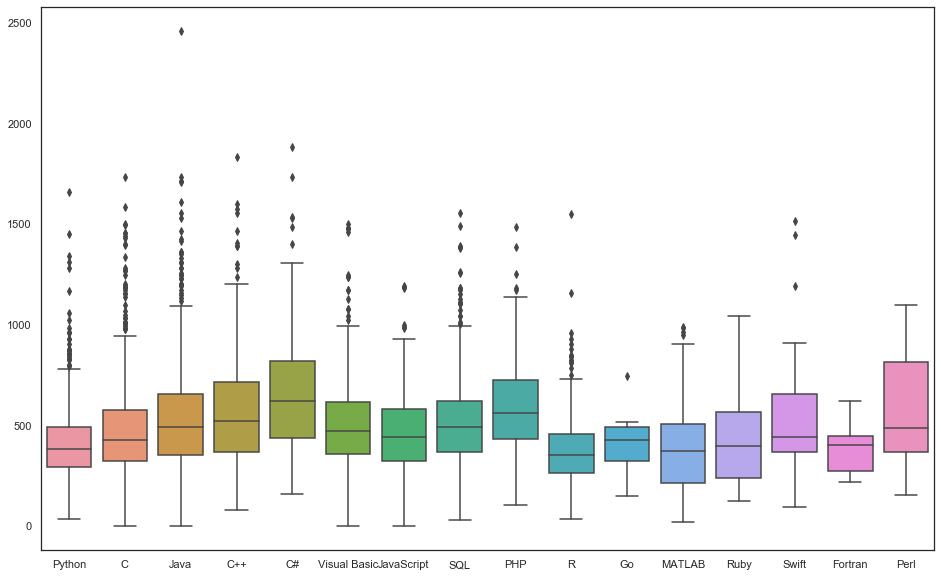

In [157]:
plt.figure(figsize=(16,10))
sns.set(font="Arial Unicode MS", rc={"axes.unicode_minus":False}, style="white")
sns.set_color_codes("pastel")
sns.boxplot(x='language', y='page_num', data=book_full)
plt.title("")
plt.ylabel("")
plt.xlabel("")
plt.show()

- 몇몇의 outlier가 있기는 하지만, Python의 경우 인기 언어 중에서 대체로 적은 페이지 수의 책이 많이 발행 되었다.
- C#의 경우 분포가 다른 인기 언어에 비해 커 보인다.


In [158]:
python_df = book_df[book_df['language'] == 'Python']
C_df = book_df[book_df['language'] == 'C']
Java_df = book_df[book_df['language'] == 'Java']
R_df = book_df[book_df['language'] == 'R']

In [159]:
big4languages = pd.concat([python_df, C_df, Java_df, R_df])

In [160]:
big4languages

,title,author,price,publisher,isbn,pubdate,keyword,link,year,language,page_num
0,JUMP TO PYTHON,박응용,17000.0,정보게이트,8981611211,20010808,Python,http://book.naver.com/bookdb/book_detail.php?b...,2001,Python,454
1,PYTHON 포켓 레퍼런스,마크 루츠,4600.0,한빛미디어,897914086X,20001010,Python,http://book.naver.com/bookdb/book_detail.php?b...,2000,Python,106
2,PYTHON AND TKINTER PROGRAMMING,JOHN E.GRAYSON,28000.0,인포북,8980544243,20001101,Python,http://book.naver.com/bookdb/book_detail.php?b...,2000,Python,852
3,PYTHON HOW TO PROGRAM,하비 디텔,45000.0,PEARSONEDUCATIONKOREA,8945071407,20021226,Python,http://book.naver.com/bookdb/book_detail.php?b...,2002,Python,1278
4,PYTHON 21일 완성,곽준기,17000.0,삼각형,8974674351,19980117,Python,http://book.naver.com/bookdb/book_detail.php?b...,1998,Python,612
...,...,...,...,...,...,...,...,...,...,...,...
4344,R&SPSS 사회과학 데이터 분석,김계수,25000.0,한나래아카데미,8955662564,20211015,R,http://book.naver.com/bookdb/book_detail.php?b...,2021,R,272
4345,R중심의 비계량인을 위한 경영통계,김선민,30000.0,한경사,8968443203,20201210,R,http://book.naver.com/bookdb/book_detail.php?b...,2020,R,420
4346,시각화를 이용한 데이터 정보분석 (R 활용),이동수|장인홍,29000.0,자유아카데미,1158082592,20200316,R,http://book.naver.com/bookdb/book_detail.php?b...,2020,R,240
4347,R로 시그마식스 따라잡기,김종일,29000.0,휴먼싸이언스,1189057131,20200110,R,http://book.naver.com/bookdb/book_detail.php?b...,2020,R,390


<Figure size 1152x720 with 0 Axes>

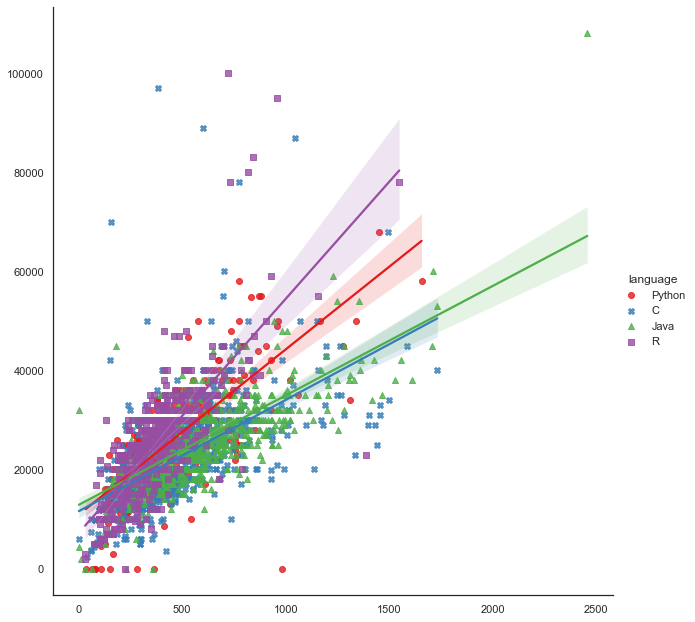

In [161]:
plt.figure(figsize=(16,10))
sns.set(font="Arial Unicode MS", rc={"axes.unicode_minus":False}, style="white")

sns.lmplot(x='page_num', y='price', hue='language', data=big4languages, palette="Set1", height=9, markers=['o', 'X', '^', 's'])
plt.ylabel("")
plt.xlabel("")
plt.show()

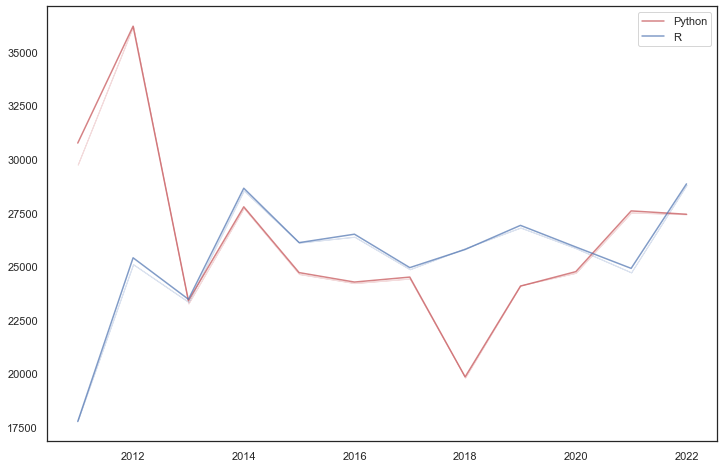

In [162]:
# 파이썬과 R 연도 카운트와 가격 비교
plt.figure(figsize=(12,8))
sns.lineplot(data=python_df[python_df['year']>2010], x='year', y='price', color='r', alpha=0.7, ci=False, label="Python")
sns.lineplot(data=R_df[R_df['year']>2010], x='year', y='price', color='b', alpha=0.7, ci=False, label='R')
plt.legend()
plt.ylabel("")
plt.xlabel("")

plt.show()

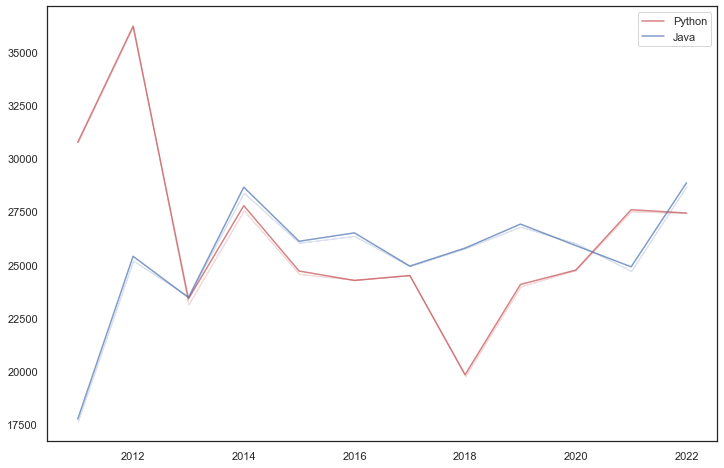

In [163]:
# 파이썬과 java 연도 카운트와 가격 비교
plt.figure(figsize=(12,8))
sns.lineplot(data=python_df[python_df['year']>2010], x='year', y='price', color='r', alpha=0.7, ci=False, label="Python")
sns.lineplot(data=R_df[R_df['year']>2010], x='year', y='price', color='b', alpha=0.7, ci=False, label='Java')
plt.legend()
plt.ylabel("")
plt.xlabel("")

plt.show()

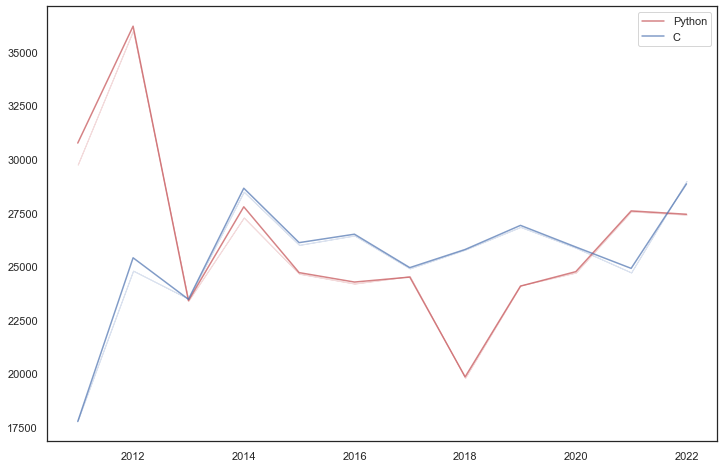

In [164]:
# 파이썬과 C 연도 카운트와 가격 비교
plt.figure(figsize=(12,8))
sns.lineplot(data=python_df[python_df['year']>2010], x='year', y='price', color='r', alpha=0.7, ci=False, label="Python")
sns.lineplot(data=R_df[R_df['year']>2010], x='year', y='price', color='b', alpha=0.7, ci=False, label='C')
plt.legend()
plt.ylabel("")
plt.xlabel("")

plt.show()